In [1]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from collections import defaultdict
from ultralytics import YOLO
from scipy import stats
from tqdm import tqdm
from PIL import Image


In [2]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

# Preprocesamiento

In [3]:
def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

In [4]:
def count_bounding_boxes(model, image_path, confidence_threshold = 0.25):
    results = model.predict(image_path, verbose=False)
    bbox_counts = defaultdict(int)

    for result in results:
        for box in result.boxes: 
            if box.conf >= confidence_threshold: 
                class_id = int(box.cls) 
                bbox_counts[class_id] += 1

    return bbox_counts

def density(model, fileData, image_path):
    count = count_bounding_boxes(model, image_path)[0]
    pixelSize = 1/fileData["Resolution"] #
    fisicWitdh = fileData["Witdh"]*pixelSize
    fisicHeigth = fileData["Heigth"]*pixelSize
    Area = fisicWitdh*fisicHeigth
    Density = count/Area * 100
    return Density

def load_labels(label_path):
    labels = defaultdict(list)
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels[class_id].append(bbox)
    return labels


# Ejemplo

In [5]:
# Recordar que las predicciones 0 son bounding chicas y 1 bounding grandes
image_path = "datasets/train/images/STMHD0007.jpg"

model = YOLO('Modelos\yolov10\HoldOutSimpleYolov10n.pt')

count_bounding_boxes(model,image_path)

defaultdict(int, {0: 66, 1: 60})

In [6]:
metadata

,FileName,Species,ScientificName,Magnification,Witdh,Heigth,Resolution
0,STMHD0001,Nuttall oak,Quercus texana Buckley,100,1024,768,118
1,STMHD0002,Nuttall oak,Quercus texana Buckley,100,1024,768,118
2,STMHD0003,Nuttall oak,Quercus texana Buckley,100,1024,768,118
3,STMHD0004,Nuttall oak,Quercus texana Buckley,100,1024,768,118
4,STMHD0005,Nuttall oak,Quercus texana Buckley,100,1024,768,118
...,...,...,...,...,...,...,...
10710,STMPP3483,Poplar,Populus L.,200,2048,1536,476
10711,STMPP3484,Poplar,Populus L.,200,2048,1536,476
10712,STMPP3485,Poplar,Populus L.,200,2048,1536,476
10713,STMPP3486,Poplar,Populus L.,200,2048,1536,476


In [7]:
PATH_images = "datasets/train/images"

counts = []
for i in tqdm(range(len(metadata))):
    fileData = metadata.iloc[i]
    path = PATH_images + f"/{fileData.FileName}.jpg"
    counts.append(count_bounding_boxes(model, path)[0])

100%|██████████| 10715/10715 [09:26<00:00, 18.92it/s]


In [9]:
PATH_labels = "datasets/train/labels"

RealCounts = []
for i in tqdm(range(len(metadata))):
    fileData = metadata.iloc[i]
    path = PATH_labels + f"/{fileData.FileName}.txt"
    real_labels = load_labels(path)
    real_counts = {class_id: len(bboxes) for class_id, bboxes in real_labels.items()}[0]
    RealCounts.append(real_counts)

100%|██████████| 10715/10715 [00:03<00:00, 3284.13it/s]


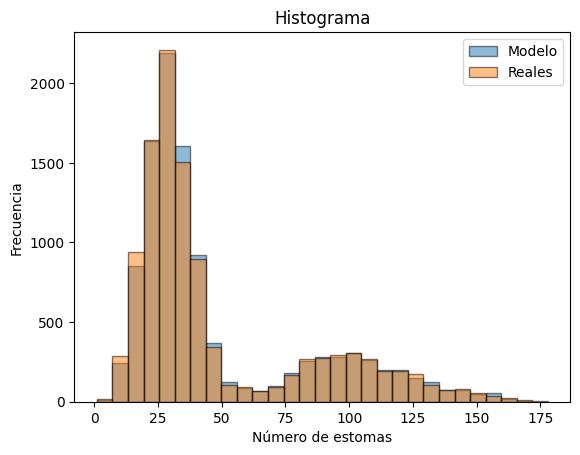

In [20]:
# Datos de ejemplo
data = counts
data2 = RealCounts

# Calculamos los histogramas (sin graficar) para obtener los bins
frequencies1, bins1 = np.histogram(data, bins=10)
frequencies2, bins2 = np.histogram(data2, bins=10)

# Encontramos los valores mínimos y máximos de los bins
min_bin = min(bins1.min(), bins2.min())
max_bin = max(bins1.max(), bins2.max())

# Creamos un rango de bins común basado en los valores mínimos y máximos
common_bins = np.linspace(min_bin, max_bin, 30)

# Crear los histogramas en el mismo eje usando los mismos bins
fig, ax = plt.subplots()
ax.hist(data, bins=common_bins, alpha=0.5, label='Modelo', edgecolor='black')
ax.hist(data2, bins=common_bins, alpha=0.5, label='Reales', edgecolor='black')

# Añadir la leyenda y etiquetas
ax.set_xlabel('Número de estomas')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma')
ax.legend()

# Mostrar el gráfico
plt.show()

# Densidades

In [49]:
PATH_images = "datasets/train/images"

Densities = []
for i in tqdm(range(len(metadata))):
    fileData = metadata.iloc[i]
    path = PATH_images + f"/{fileData.FileName}.jpg"
    Densities.append(density(model, fileData, path))
    

100%|██████████| 10715/10715 [09:57<00:00, 17.95it/s]


In [68]:
species = metadata["Species"].unique()
densityPerPlant = []
for s in species:
    index = metadata[metadata["Species"] == s].index
    densityPlant = []
    for i in index:
        densityPlant.append(Densities[i])
    densityPerPlant.append(densityPlant)
    

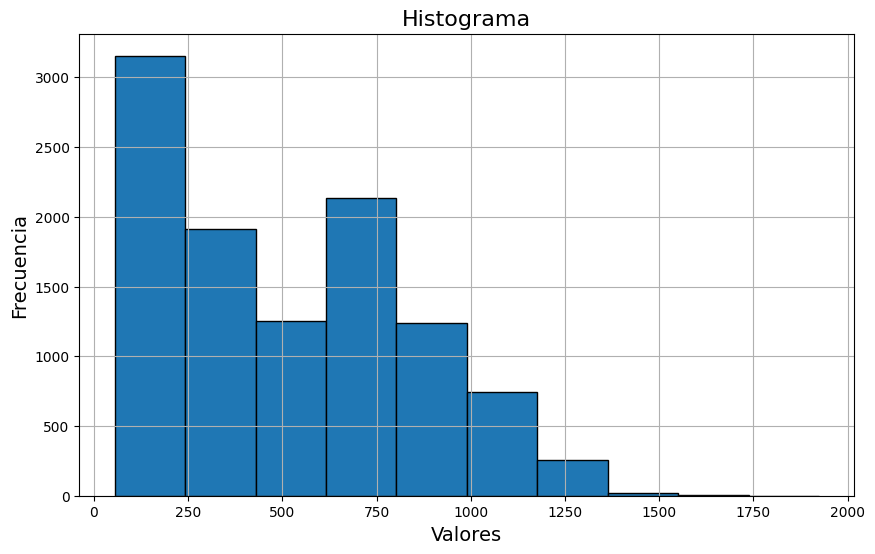

In [95]:
# Datos de ejemplo
data = Densities

# Crear el histograma
plt.figure(figsize=(10,6))  # Tamaño de la figura
plt.hist(data, edgecolor='black')  # Cambia 'data' por tus datos

# Añadir título y etiquetas
plt.title('Histograma', fontsize=16)
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el gráfico
plt.grid(True)
plt.show()